# Complex Networks analysis
### Hugo Barbosa
hbarbosa@pas.rochester.edu

## Part 2
11. Exercise - Film actor network
    10. Bipartite Networks
    7. Inspecting the network structure
      2. Components
      3. Paths
      5. Spanning tree
    8. Community Analysis  

# The film actors network
Here we're going to build and analyze a network of actors  who have appeared in the same movie. 

## The data
```
id,actor_name,character,film_name,year
0,David A. R. White,Adam Riley,The Moment After 2: The Awakening,2006
1,Lonnie Colon,'Captain' Robert Jackson,The Moment After 2: The Awakening,2006
2,Brad Heller,Jacob Krause,The Moment After 2: The Awakening,2006
3,Logan White,Carissa,The Moment After 2: The Awakening,2006
```

http://www.pas.rochester.edu/~hbarbosa/film_actors.csv

or

https://goo.gl/Pbc2Nz



## The tools
First, we'll need two libraries:
 - igraph 
 - pandas


### Reading the data

In [228]:
%matplotlib inline
import pandas as pd

In [162]:
df = pd.read_csv('http://www.pas.rochester.edu/~hbarbosa/film_actors.csv')
df.head()

,id,actor_name,character,film_name,year
0,0,David A. R. White,Adam Riley,The Moment After 2: The Awakening,2006
1,1,Lonnie Colon,'Captain' Robert Jackson,The Moment After 2: The Awakening,2006
2,2,Brad Heller,Jacob Krause,The Moment After 2: The Awakening,2006
3,3,Logan White,Carissa,The Moment After 2: The Awakening,2006
4,4,Monte Perlin,Commander Fredericks,The Moment After 2: The Awakening,2006


### Filtering the data
* Some analyses are very time consuming.
* Let's restrict our exercise to movies released in 2010.

In [227]:
df2010 = df[df['year'] == 2010]
df2010.head()

,id,actor_name,character,film_name,year
268,268,Keena Ferguson,Angelica,Consinsual,2010
269,269,Robert Joseph,Devon,Consinsual,2010
270,270,Bryan Keith,Dillon,Consinsual,2010
271,271,Siaka Massaquoi,Terrence,Consinsual,2010
272,272,Kathryn Taylor,Jasmine,Consinsual,2010


## Some more filtering...
### Some actors have same name as some of the movies in our data

In [230]:
df2010[df2010['actor_name'].isin(df2010['film_name'])]

,id,actor_name,character,film_name,year
63453,63453,Diplo,NaN,Diplo,2010
81072,81072,Magic,Dwayne,Sinners and Saints,2010


### Let's filter them out

In [232]:
df2010 = df2010[ ~df2010['actor_name'].isin(df2010['film_name'])]

#### Let's now remove those titles with less than 5 actors
First, we need to count the number of actors appearing in each film

In [242]:
casts = df2010.groupby(['film_name'])['actor_name'].nunique()

### Filtering out titles with less than 5 actors

In [461]:
large_casts = casts[casts >= 5 ]
large_casts.head()

film_name
#1 Cheerleader Camp    58
127 Hours              16
13                     11
15 Minutes              7
16 Wishes              10
Name: actor_name, dtype: int64

In [462]:
major = df2010[df2010['film_name'].isin(large_casts.index)]
major.head()

,id,actor_name,character,film_name,year
268,268,Keena Ferguson,Angelica,Consinsual,2010
269,269,Robert Joseph,Devon,Consinsual,2010
270,270,Bryan Keith,Dillon,Consinsual,2010
271,271,Siaka Massaquoi,Terrence,Consinsual,2010
272,272,Kathryn Taylor,Jasmine,Consinsual,2010


### Now we want lists of unique actors and film titles

In [463]:
actors = major['actor_name'].unique()
actors[:3]

array(['Keena Ferguson', 'Robert Joseph', 'Bryan Keith'], dtype=object)

In [464]:
films = major['film_name'].unique()
films[:3]

array(['Consinsual', 'Elektra Luxx', 'A Buddy Story'], dtype=object)

In [465]:
n_actors = len(actors)
n_films = len(films)
print "# of actors: ",n_actors
print "# of films: ",n_films

# of actors:  13604
# of films:  1178


# Building a bipartite network
<img src="bipartite_sample.png"></img>

## Let's start with an empty graph 

In [466]:
g = ig.Graph()

### Creating  the vertices list and adding them to the network

In [467]:
vertices = list(films) + list(actors)

In [468]:
g.add_vertices(vertices)
g.summary()

'IGRAPH UN-- 14782 0 -- \n+ attr: name (v)'


### Now, we'll create the edges list and add them to our network

In [469]:
edges = major[['actor_name','film_name']].values
edges[:5]

array([['Keena Ferguson', 'Consinsual'],
       ['Robert Joseph', 'Consinsual'],
       ['Bryan Keith', 'Consinsual'],
       ['Siaka Massaquoi', 'Consinsual'],
       ['Kathryn Taylor', 'Consinsual']], dtype=object)

In [470]:
g.add_edges(edges)
g.summary()

'IGRAPH UN-- 14782 16697 -- \n+ attr: name (v)'

#### For the bipartite projection, we need to set an attribute specifying nodes' types
 - 0: films
 - 1: actors/actresses 
 
For such, we're going to use some Python trickery.

In [471]:
print ['Hello']*3

['Hello', 'Hello', 'Hello']


In [472]:
print [0]*3 + [1]*3

[0, 0, 0, 1, 1, 1]


#### Since all we need is a list with `n_films` zeros and `n_actors` ones...

In [473]:
g.vs['type'] = [0]*n_films + [1]*n_actors 

### Now, the bipartite projection

In [474]:
g_actors = g.bipartite_projection(which=1)
g_actors.summary()

'IGRAPH UNWT 13604 164076 -- \n+ attr: name (v), type (v), weight (e)'

In [475]:
gc = g_actors.components().giant()
gc.summary()

'IGRAPH UNWT 11504 151490 -- \n+ attr: name (v), type (v), weight (e)'

## Network measures

### Clustering coefficient

In [476]:
gc.transitivity_undirected()

0.7760963173523067

### Density

In [477]:
gc.density()

0.0022895702239858332

### Diameter

In [478]:
gc.diameter()

12

### Avg. path length

In [479]:
gc.average_path_length()

4.504624390782982

### What about Kevin Bacon?

In [480]:
bacon = gc.vs.find(name_eq='Kevin Bacon')
bacon_shortest_paths = bacon.shortest_paths()

In [481]:
np.sum(bacon_shortest_paths)/(gc.vcount()-1.0)

3.7473702512388072

In [482]:
1.0/bacon.closeness()

3.747370251238807

## Centrality measures

In [483]:
betw = gc.betweenness(weights='weight' )
closeness = gc.closeness(weights='weight' )
pr = gc.pagerank(weights='weight' )
dc = gc.degree()

In [484]:
gc_data = pd.DataFrame({'name':gc.vs['name'],
                        'betweenness':betw,
                        'closeness':closeness,
                        'pagerank':pr,
                        'degree':dc
                       })

### Top-5 - Degree

In [304]:
gc_data.sort_values(['degree'],ascending=False).head()

,betweenness,closeness,degree,name,pagerank
2388,4.314689e+05,0.265028,221,Matt Lagan,0.000370
850,1.110852e+06,0.299115,215,Edrick Browne,0.000585
2391,2.697521e+05,0.258215,212,David Dustin Kenyon,0.000339
2404,1.313123e+05,0.253093,191,Gregory Paul Smith,0.000282
272,8.255282e+05,0.298655,190,Lance E. Nichols,0.000533


### Top-5 - Pagerank

In [305]:
gc_data.sort_values(['pagerank'],ascending=False).head()

,betweenness,closeness,degree,name,pagerank
1365,1.726836e+06,0.303955,167,Danny Trejo,0.000599
850,1.110852e+06,0.299115,215,Edrick Browne,0.000585
272,8.255282e+05,0.298655,190,Lance E. Nichols,0.000533
2162,1.565863e+06,0.303736,159,Michael Rooker,0.000481
2527,2.048758e+05,0.266658,75,Carlos Alazraqui,0.000463


### Top-5 - Closeness

In [306]:
gc_data.sort_values(['closeness'],ascending=False).head()

,betweenness,closeness,degree,name,pagerank
899,1.234664e+06,0.307807,136,Nick Stahl,0.000436
1365,1.726836e+06,0.303955,167,Danny Trejo,0.000599
2162,1.565863e+06,0.303736,159,Michael Rooker,0.000481
1441,7.494987e+05,0.299399,151,Keith David,0.000423
457,8.649899e+05,0.299266,177,Bai Ling,0.000427


### Top-5 - Betweenness

In [308]:
gc_data.sort_values(['betweenness'],ascending=False).head()

,betweenness,closeness,degree,name,pagerank
1365,1.726836e+06,0.303955,167,Danny Trejo,0.000599
2162,1.565863e+06,0.303736,159,Michael Rooker,0.000481
899,1.234664e+06,0.307807,136,Nick Stahl,0.000436
850,1.110852e+06,0.299115,215,Edrick Browne,0.000585
311,9.673284e+05,0.283275,105,Eric Roberts,0.000398


# Community analysis

In [317]:
comms = gc.community_label_propagation(weights='weight')

### Modularity

In [341]:
comms.modularity

0.8107362733107005

### Clusters' sizes

(array([  79.,  122.,  163.,   64.,   36.,   32.,   19.,   18.,   15.,
          10.,    9.,    3.,    2.,    6.,    7.,    5.,    1.,    2.,
           1.,    0.,    2.,    1.,    0.,    0.,    0.,    1.,    0.,
           0.,    0.,    1.]),
 array([   4. ,    7.4,   10.8,   14.2,   17.6,   21. ,   24.4,   27.8,
          31.2,   34.6,   38. ,   41.4,   44.8,   48.2,   51.6,   55. ,
          58.4,   61.8,   65.2,   68.6,   72. ,   75.4,   78.8,   82.2,
          85.6,   89. ,   92.4,   95.8,   99.2,  102.6,  106. ]),
 <a list of 30 Patch objects>)

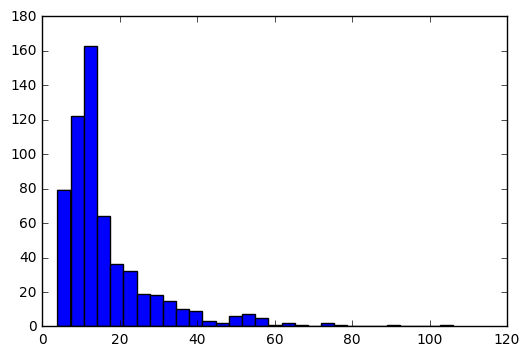

In [327]:
plt.hist(comms.sizes(),bins=30)

## Analyzing the largest community

In [411]:
largest_comm_idx = np.argmax(comms.sizes())
print largest_comm_idx
largest_comm = comms.subgraph( largest_comm_idx   )

11


In [413]:
layout = largest_comm.layout_auto()

In [347]:
comms_lp = largest_comm.community_label_propagation(weights='weight')
comms_eb = largest_comm.community_edge_betweenness(weights='weight')
comms_fg = largest_comm.community_fastgreedy(weights='weight')
comms_le = largest_comm.community_leading_eigenvector(weights='weight')
comms_sg = largest_comm.community_spinglass(weights='weight')
comms_ml = largest_comm.community_multilevel(weights='weight')

In [384]:
print comms_lp.modularity
print comms_fg.as_clustering().modularity 
print comms_le.modularity 
print comms_eb.as_clustering().modularity 
print comms_sg.modularity
print comms_ml.modularity

0.418510810498
0.428377702625
0.421674037461
0.423863018846
0.435455688519
0.435809775697


### Label propagation

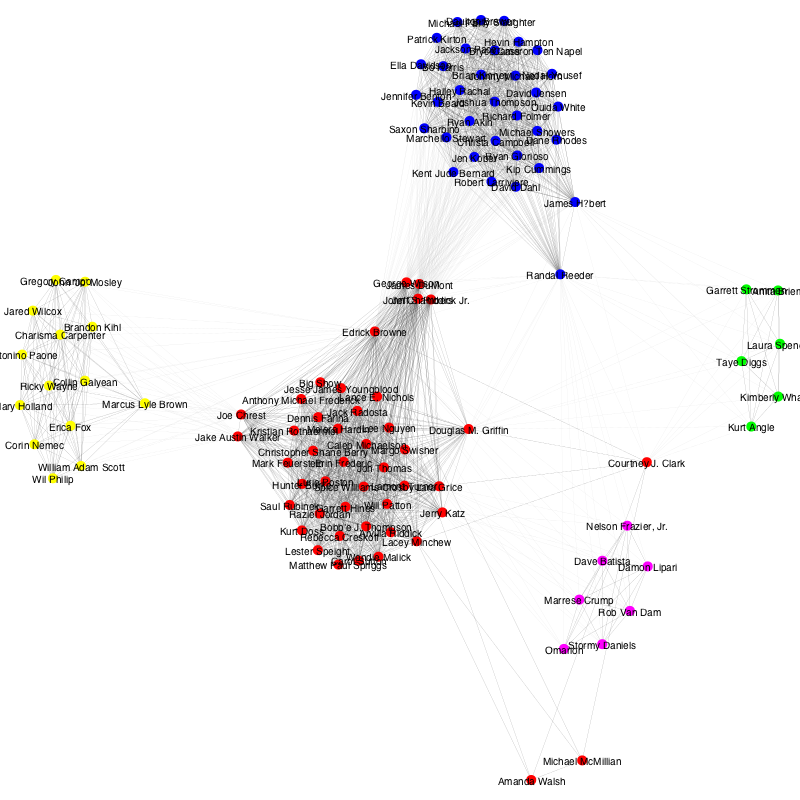

In [415]:
ig.plot(comms_lp,
        vertex_label=largest_comm.vs['name'],
        layout=layout,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )

### Edge betweenness

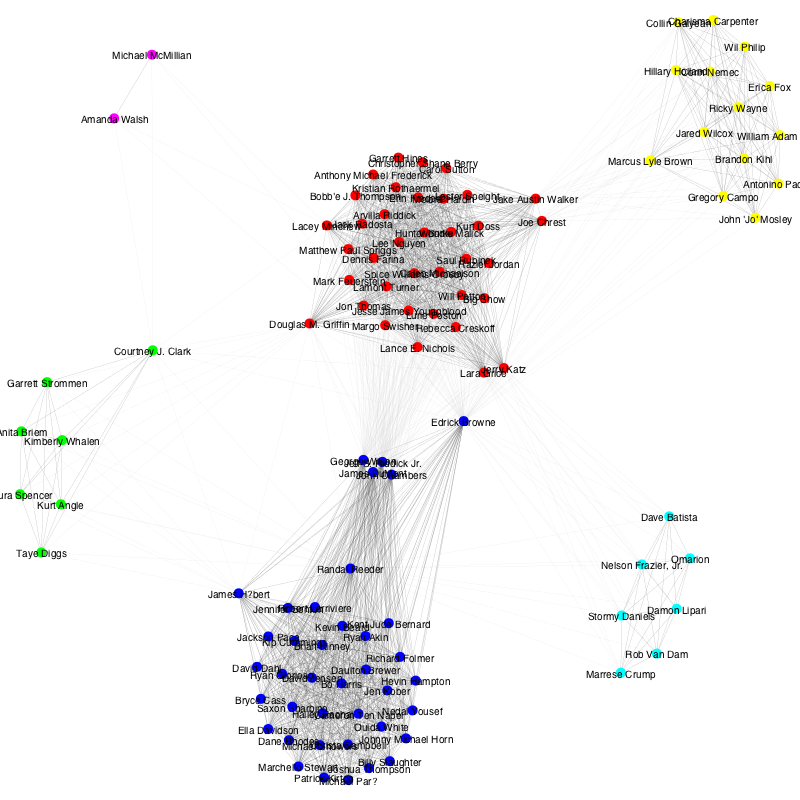

In [416]:
ig.plot(comms_eb.as_clustering(),
        vertex_label=largest_comm.vs['name'],
        layout=layout2,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )

### Fastgreedy 

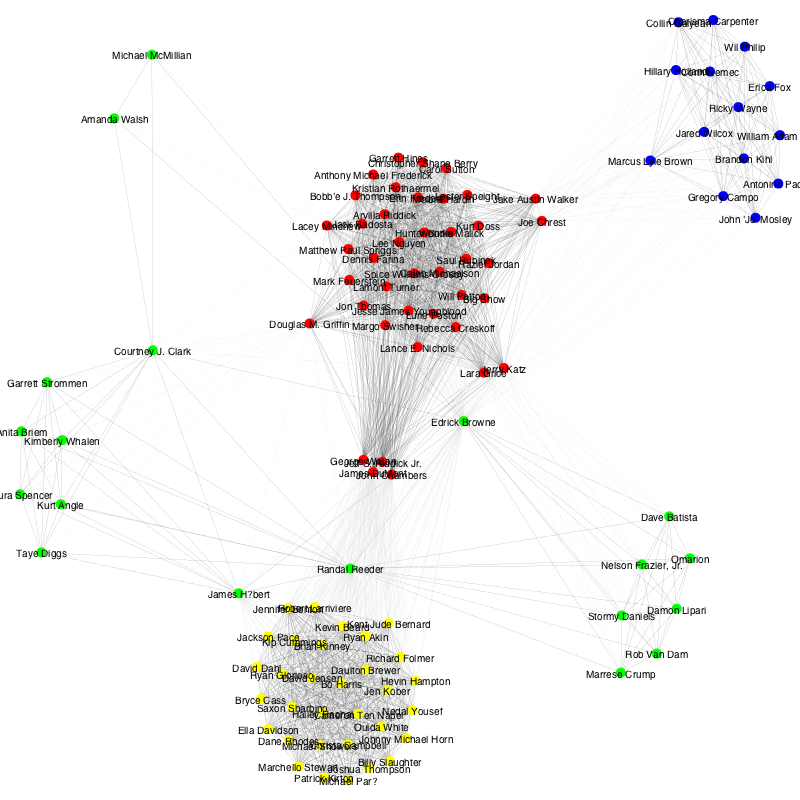

In [417]:
ig.plot(comms_fg.as_clustering(),
        vertex_label=largest_comm.vs['name'],
        layout=layout2,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )

### Leading eigenvector

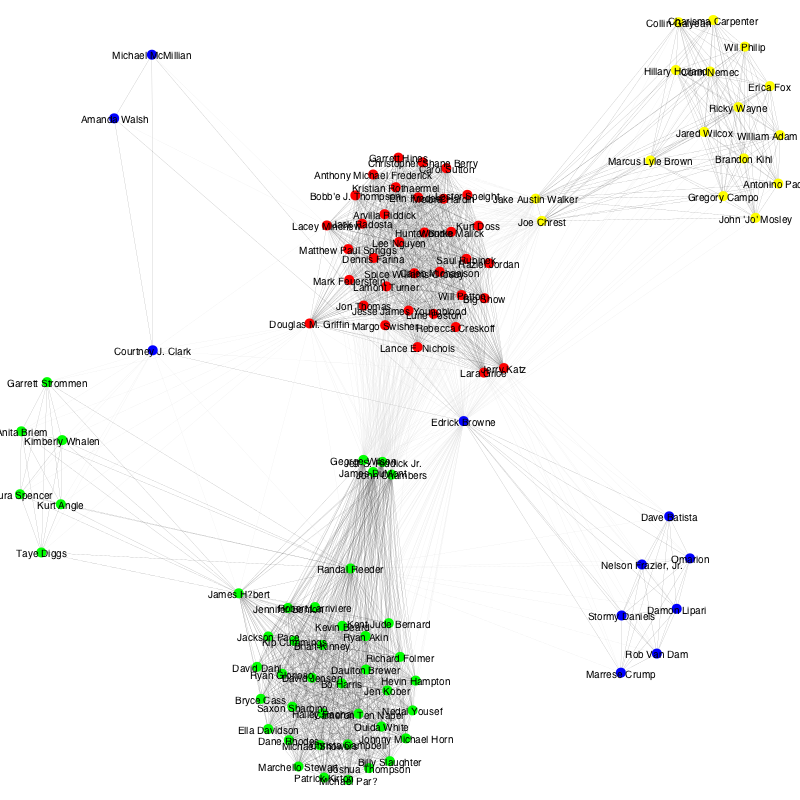

In [418]:
ig.plot(comms_le,
#         mark_groups=True,
        vertex_label=largest_comm.vs['name'],
        layout=layout2,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )

### Spinglass

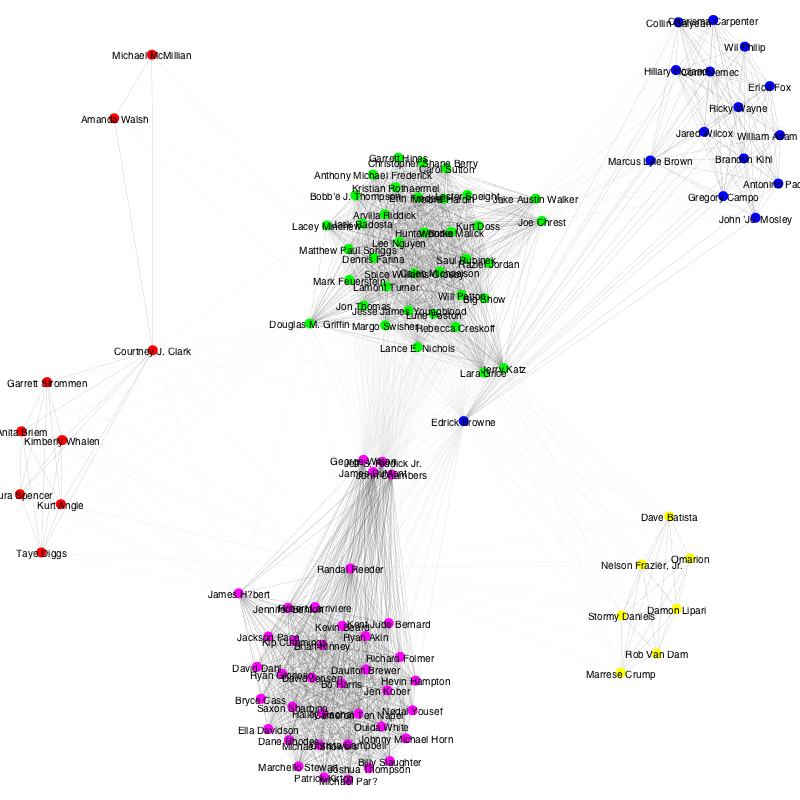

In [419]:
ig.plot(comms_sg,
#         mark_groups=True,
        vertex_label=largest_comm.vs['name'],
        layout=layout2,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )

### Multilevel

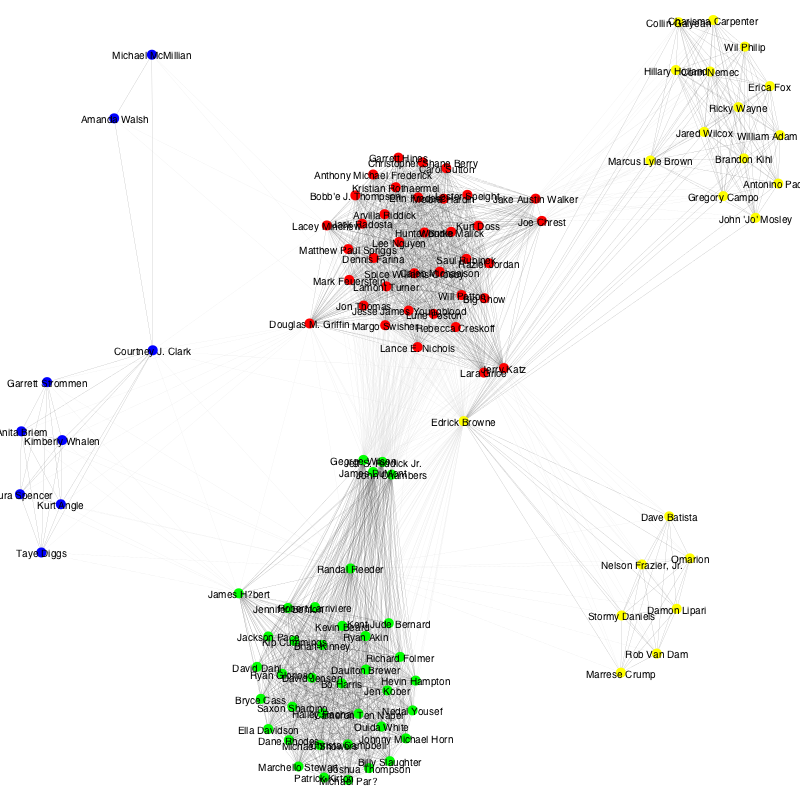

In [420]:
ig.plot(comms_ml,
#         mark_groups=True,
        vertex_label=largest_comm.vs['name'],
        layout=layout2,
        vertex_frame_width=0,
        edge_width=0.1,
        vertex_label_size=10,
        vertex_size=10,
        bbox=(0,0,800,800)

       )